In [1]:
from __future__ import print_function
%matplotlib inline
from obspy.signal.cross_correlation import xcorr_pick_correction
from obspy.clients.fdsn import Client as fdsnClient
from obspy import read, UTCDateTime , signal
from obspy.signal.cross_correlation import correlation_detector
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import lowpass
from obspy import *
import obspy
import shapely.geometry as sgeom
import numpy as np
from obspy.geodetics import gps2dist_azimuth as gps2DistAzimuth
from IPython.display import Image
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

c_fdsn = fdsnClient('IRIS')

1. Filters

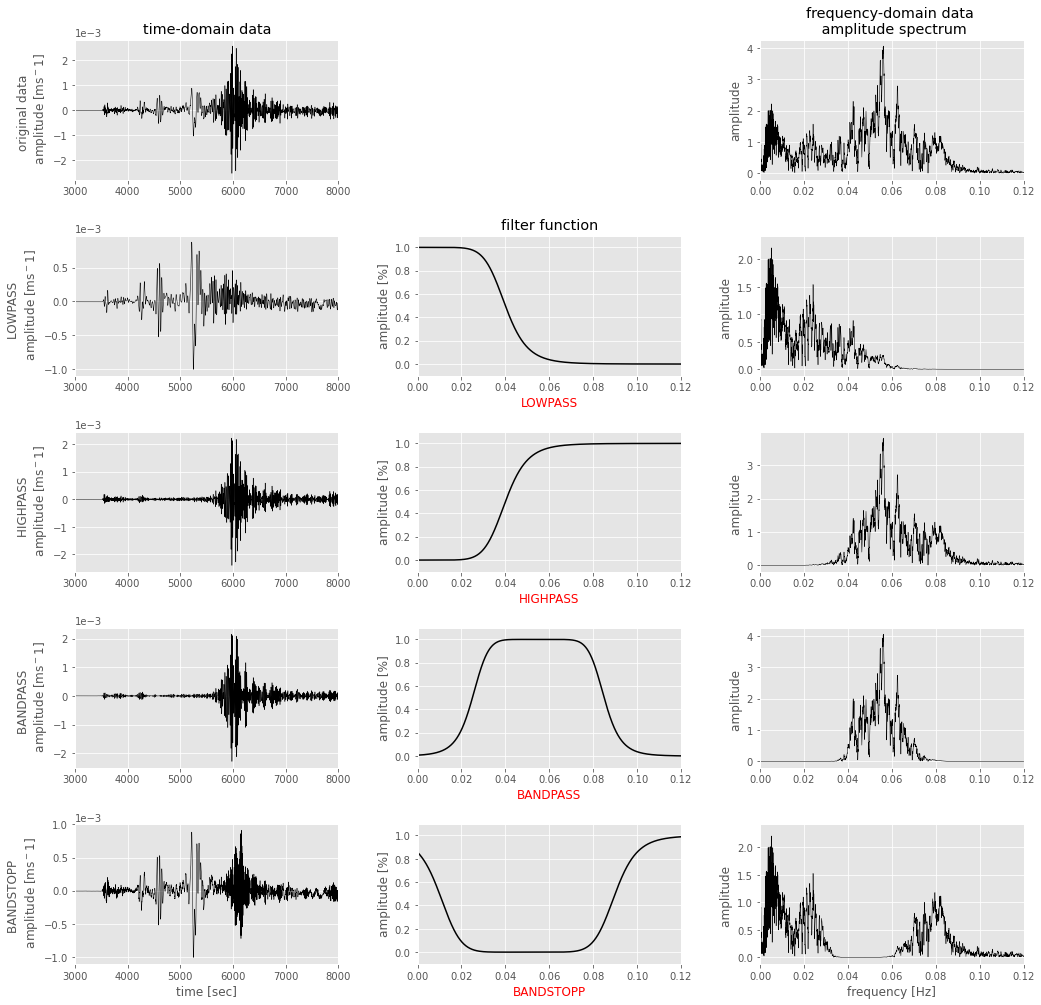

In [2]:
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5
client = fdsnClient("BGR")
t1 = UTCDateTime("2011-03-11T05:00:00.000")
st = client.get_waveforms("GR", "WET", "", "BHZ", t1, t1 + 6 * 60 * 60,
                          attach_response = True)
st.remove_response(output="VEL")
st.detrend('linear')
st.detrend('demean')
npts = st[0].stats.npts                   # number of samples in the trace
dt = st[0].stats.delta                    # sample interval
fNy = 1. / (2. * dt)                      # Nyquist frequency
time = np.arange(0, npts) * dt            # time axis for plotting
freq = np.linspace(0, fNy, npts // 2 + 1) # frequency axis for plotting
corners = 4                               # order of filter
# several filter frequencies for the different filter types
f0 = 0.04
fmin1 = 0.04
fmax1 = 0.07
fmin2 = 0.03
fmax2 = 0.07

# filter functions
LP = 1 / ( 1 + (freq / f0) ** (2 * corners))
HP = 1 - 1 / (1 + (freq / f0) ** (2 * corners))
wc = fmax1 - fmin1
wb = 0.5 * wc + fmin1
BP = 1/(1 + ((freq - wb) / wc) ** (2 * corners))
wc = fmax2 - fmin2
wb = 0.5 * wc + fmin2
BS = 1 - ( 1 / (1 + ((freq - wb) / wc) ** (2 * corners)))

# filtered traces
stHP = st.copy()
stHP.filter('highpass', freq=f0, corners=corners, zerophase=True)
stLP = st.copy()
stLP.filter('lowpass', freq=f0, corners=corners, zerophase=True)
stBP = st.copy()
stBP.filter('bandpass', freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
stBS = st.copy()
stBS.filter('bandstop', freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)

# amplitude spectras
Ospec = np.fft.rfft(st[0].data)
LPspec = np.fft.rfft(stLP[0].data)
HPspec = np.fft.rfft(stHP[0].data)
BPspec = np.fft.rfft(stBP[0].data)
BSspec = np.fft.rfft(stBS[0].data)

plt.rcParams['figure.figsize'] = 17, 17
tx1 = 3000
tx2 = 8000
fx2 = 0.12

fig = plt.figure()

ax1 = fig.add_subplot(5,3,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, st[0].data, 'k')
plt.xlim(tx1, tx2)
plt.title('time-domain data')
plt.ylabel('original data \n amplitude [ms$^-1$]')

ax3 = fig.add_subplot(5,3,3)
plt.plot(freq, abs(Ospec), 'k')
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
plt.xlim(0,fx2)

ax4 = fig.add_subplot(5,3,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stLP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('LOWPASS  \n amplitude [ms$^-1$]')

ax5 = fig.add_subplot(5,3,5)
plt.plot(freq, LP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.title('filter function')
plt.ylabel('amplitude [%]')
plt.xlabel('LOWPASS', color='r')

ax6 = fig.add_subplot(5,3,6)
plt.plot(freq, abs(LPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax7 = fig.add_subplot(5,3,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stHP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('HIGHPASS  \n amplitude [ms$^-1$]')

ax8 = fig.add_subplot(5,3,8)
plt.plot(freq, HP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('HIGHPASS', color='r')

ax9 = fig.add_subplot(5,3,9)
plt.plot(freq, abs(HPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)


ax10 = fig.add_subplot(5,3,10)
ax10.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('BANDPASS  \n amplitude [ms$^-1$]')


ax11 = fig.add_subplot(5,3,11)
plt.plot(freq, BP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('BANDPASS', color='r')

ax12 = fig.add_subplot(5,3,12)
plt.plot(freq, abs(BPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax13 = fig.add_subplot(5,3,13)
ax13.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBS[0].data, 'k')
plt.xlim(tx1, tx2)
plt.xlabel('time [sec]')
plt.ylabel('BANDSTOPP \n amplitude [ms$^-1$]')


ax14 = fig.add_subplot(5,3,14)
plt.plot(freq, BS, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('frequency [Hz]')
plt.xlabel('BANDSTOPP', color='r')

ax15 = fig.add_subplot(5,3,15)
plt.plot(freq, abs(BSspec), 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


2. Causal versus acausal

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


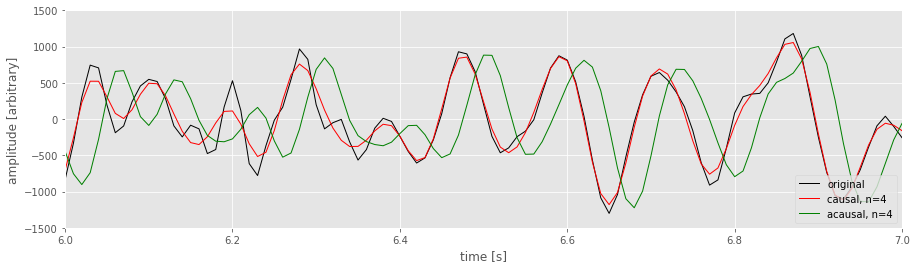

In [3]:
stf = read()                   # load example seismogram
tr = stf[0]                    # select the first trace in the Stream object
tr.detrend('demean')           # preprocess data
tr.detrend('linear')
tr.filter("highpass", freq=2)  # removing long-period noise
print(tr)
t = tr.times()                 # time vector for x axis

f = 15.0                       # frequency for filters (intial: 10 Hz)
start = 4                      # start time to plot in sec (initial: 4)
end = 8                        # end time to plot in sec (initial: 8)
amp = 1500                     # amplitude range for plotting (initial: 1500)
ncorners = 4                   # number of corners/order of the filter (initial: 4)

# tr_filt = tr.copy()            # causal filter / not zero phase. Order = 2
# tr_filt.filter('lowpass', freq=f, zerophase=True, corners=2)
tr_filt2 = tr.copy()           # causal filter / not zero phase. Order = set by ncorners
tr_filt2.filter('lowpass', freq=f, zerophase=True, corners=ncorners)
tr_filt3 = tr.copy()           # acausal filter / zero phase. Order = set by ncorners
tr_filt3.filter('lowpass', freq=f, zerophase=False, corners=ncorners)

# plot - comment single lines to better see the remaining ones
plt.rcParams['figure.figsize'] = 15, 4
plt.plot(t, tr.data, 'k', label='original', linewidth=1.)
# plt.plot(t, tr_filt.data, 'b', label='causal, n=2', linewidth=1)
plt.plot(t, tr_filt2.data, 'r', label='causal, n=%s' % ncorners, linewidth=1)
plt.plot(t, tr_filt3.data, 'g', label='acausal, n=%s' % ncorners, linewidth=1)

plt.xlabel('time [s]')
plt.xlim(start+2, end-1)
plt.ylim(-amp, amp)
plt.ylabel('amplitude [arbitrary]')
plt.legend(loc='lower right')

plt.show()

3. Decimation

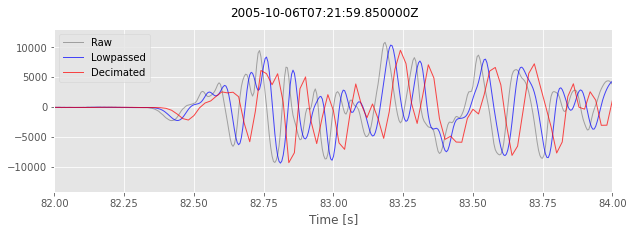

In [4]:
plt.rcParams['figure.figsize'] =10, 3
plt.rcParams['lines.linewidth'] = 1
st1 = read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
tr1 = st1[0]
# Decimate the 200 Hz data by a factor of 4 to 50 Hz. Note that this
# automatically includes a lowpass filtering with corner frequency 20 Hz.
# We work on a copy of the original data just to demonstrate the effects of
# downsampling.
tr_new = tr1.copy()
tr_new.decimate(factor=4, strict_length=False)

# For comparison also only filter the original data (same filter options as in
# automatically applied filtering during downsampling, corner frequency
# 0.4 * new sampling rate)
tr_filt = tr1.copy()
tr_filt.filter('lowpass', freq=0.4 * tr1.stats.sampling_rate / 4.0)

t = np.arange(0, tr1.stats.npts / tr1.stats.sampling_rate, tr1.stats.delta)
t_new = np.arange(0, tr_new.stats.npts / tr_new.stats.sampling_rate,
                  tr_new.stats.delta)

plt.plot(t, tr1.data, 'k', label='Raw', alpha=0.3)
plt.plot(t, tr_filt.data, 'b', label='Lowpassed', alpha=0.7)
plt.plot(t_new, tr_new.data, 'r', label='Decimated', alpha=0.7)
plt.xlabel('Time [s]')
plt.xlim(82, 84)
plt.suptitle(tr1.stats.starttime)
plt.legend()
plt.show()

4. Downsampling + Nyquist

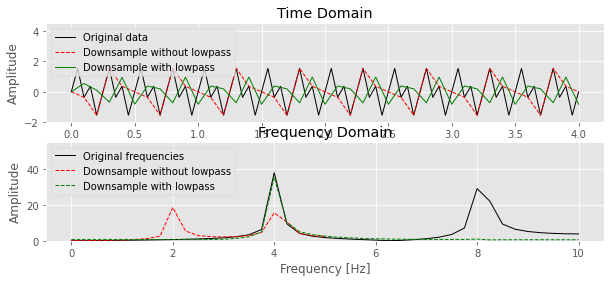

In [5]:
plt.rcParams['figure.figsize'] = 10, 4
npts = 512                              # number of samples
nsec = 4                              # length of signal in seconds
df = 20                              # sampling rate
fNy = df / 2.0                          # Nyquist frequency
fg1 = 8                                 # generator frequency 1 (initial: 8 Hz)
fg2 = 4                                 # generator frequency 2 (initial: 4 Hz)
time = np.linspace(0,nsec,(nsec*df)+1)  # time axis for plotting

y  = np.sin(2 * np.pi * fg1 * time)     # set up a test signal from two frequencies
y += np.sin(2 * np.pi * fg2 * time)

# downsample to 10 Hz by taking every second element
y_2 = y[::2]

# downsample after lowpassing the signal
y_l = lowpass(y, 5.0, df=df, corners=4, zerophase=False)
y_new = y_l[::2]

y_f = np.fft.rfft(y)                    # transform all 3 signals into frequency domain
y_f2 = np.fft.rfft(y_2)                 # applying Fourier transformation via FFT
y_fnew = np.fft.rfft(y_l)
freq = np.linspace(0, fNy, len(y_f))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(time, y, 'k', label="Original data", lw=1)
plt.plot(time[::2], y_2, 'r--', label="Downsample without lowpass", lw=1)
plt.plot(time[::2], y_new, 'g', label="Downsample with lowpass", lw=1)
plt.legend()
plt.ylim(-2, 4.5)
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(freq, abs(y_f), 'k', label="Original frequencies", lw=1)
plt.plot(freq[:len(y_f2)], abs(y_f2), 'r--', label="Downsample without lowpass", lw=1)
plt.plot(freq[:len(y_fnew)], abs(y_fnew), 'g--', label="Downsample with lowpass", lw=1)
plt.legend()
plt.ylim(0, 55)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

5. Tapping


Before Taper
amplitude of first sample point:   2.0
amplitude of last sample point:  -0.6
After Taper
amplitude of first sample point:   0.0
amplitude of last sample point:  -0.0


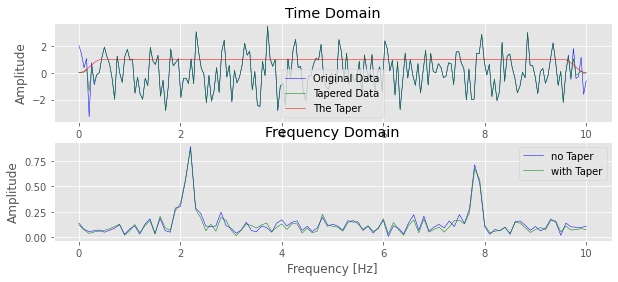

In [6]:
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5
samp = 200                                # number of sample point (initial: 200)
delta = 0.05                              # sample spacing (initial: 0.05)
freq1 = 2.15                              # generator freq to create signal (initial: 2.15)
freq2 = 7.8                               # generator freq to create signal (initial: 7.8)
temp = np.linspace(0.0, samp*delta, samp) # time axis in seconds

# generate freq1 Hz sine wave signal
dat = np.sin(freq1 * 2.0 * np.pi * temp)
# add an offset for the zero point of the sinewave
dat = np.sin(freq1 * 2.0 * np.pi * temp + np.pi/3)
# add another sinusoid to signal with freq2 Hz
dat = dat + np.sin(freq2 * 2.0 * np.pi * temp + np.pi/3)
noise_amplitude = 0.7
# add noise to the signal
dat = dat + np.random.randn(len(dat)) * noise_amplitude
# determine max. amplitude of data (for plotting)
maximum = max(dat)

print('Before Taper')
print('amplitude of first sample point:%6.1f' %dat[0])
print('amplitude of last sample point:%6.1f' %(dat[len(dat)-1]))

# percentage of taper applied [0. ; 1.] (initial: 0.1)
taper_percentage = 0.1
# define taper window
taper = cosine_taper(samp,taper_percentage)
# taper the signal
dat_taper = dat * taper

print('After Taper')
print('amplitude of first sample point:%6.1f' %dat_taper[0])
print('amplitude of last sample point:%6.1f' %(dat_taper[len(dat_taper)-1]))

# FFT data into frequency-domain
Fdat = np.fft.rfft(dat, n=samp)
Fdat_taper = np.fft.rfft(dat_taper, n=samp)
# x-axis in f-domain for plotting
xf = np.linspace(0.0, 1.0/(2.0*delta), (samp//2)+1)

# plot
plt.subplot(211)
plt.title('Time Domain')
plt.plot(temp, dat, label="Original Data", color='b', linewidth=0.5)
plt.plot(temp, dat_taper, label="Tapered Data", color='g',linewidth=0.5)
plt.plot(temp, taper, label="The Taper", color='r', linewidth=0.5)
plt.legend(loc='lower center')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.ylim(-(maximum+0.2),maximum+0.2)
# plt.xlim(-0.5,samp*delta+0.5)
plt.subplot(212)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/samp * np.abs(Fdat), color='b',label="no Taper",linewidth=0.5)
plt.plot(xf, 2.0/samp * np.abs(Fdat_taper), label="with Taper", color='g',linewidth=0.5)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

6. Trends


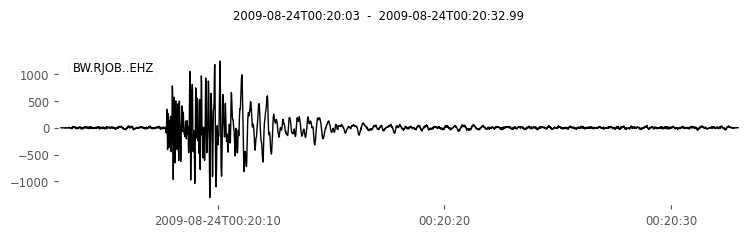

In [7]:
# Cell 6 - load the data
st = read()             # read in example seismogram included in obspy
tr = st[0]                    # take only the vertical trace of the stream
tr.filter("highpass", freq=2) # removing long-period noise
tr.plot()
tr_safe = tr.copy()

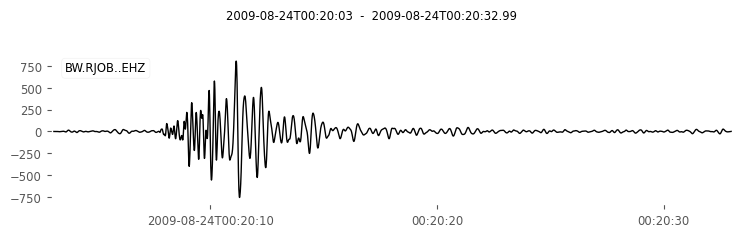

In [8]:
# offsets

tr = tr_safe.copy()       # load a fresh version of the data
tr.data += 500            # creating an offset
tr.detrend('demean')     # correction
tr.filter('bandpass', freqmin=0.01, freqmax=5)
tr.plot()
pass

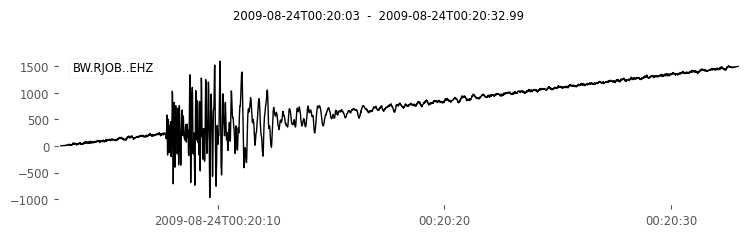

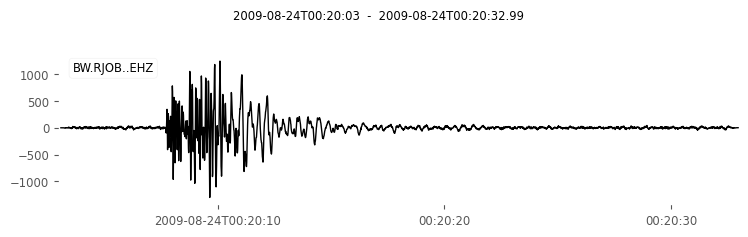

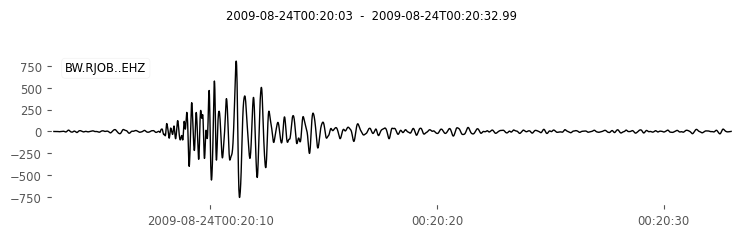

In [9]:
# linear trend
tr = tr_safe.copy()         # load a fresh version of the data
tr.data += 50. * tr.times() # creating a linear trend
tr.plot()
tr.detrend('linear')       # correction
tr.plot()
tr.filter('bandpass', freqmin=0.01, freqmax=5.)
tr.plot()
pass

In [ ]:
# any polynomial trend
# load a fresh version of the data
tr = tr_safe.copy()
# "spoiling" the data
tr.data += 6000 + 4 * tr.times() ** 2
# further "spoiling" the data
tr.data -= 0.1 * tr.times() ** 3 + 0.00001 * tr.times() ** 5

tr.plot()
tmp = tr.copy()
tmp.filter('bandpass', freqmin=0.01, freqmax=5)
tmp.plot()

# taking the data as array out of trace container
data = tr.data
# correct the spoiled data and plot+print it
signal.detrend.polynomial(data, order=3, plot=True)

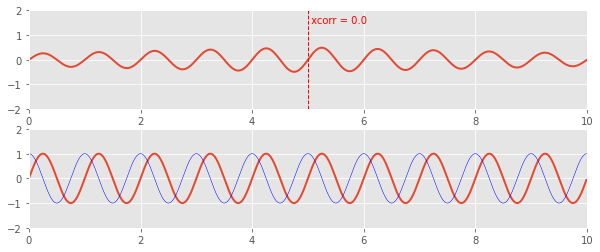

In [10]:


x = np.linspace(0, 10, 100)
fs = 100 # Sampling rate
t = np.arange(0, 10, 1/fs)
signal1 = np.sin(2 * np.pi * t)
signal2 = np.cos(2 * np.pi * t)

fig, ax = plt.subplots(2)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(-2, 2)
ax[1].set_xlim(0, 10)
ax[1].set_ylim(-2, 2)

line, = ax[1].plot([], [], lw=2)
line2, = ax[0].plot([], [], lw=2)
val = ax[0].text(5, 1.5, '', color='r')
max_label = ax[0].text(5, 1.2, '', color='r')
ax[0].plot([5, 5], [-2, 2], 'r--', lw=1)
max_val=0

def update(frame):
    shifted_signal1 = np.roll(signal1, frame)
    cross_corr = np.correlate(shifted_signal1, signal2, mode='same')/ len(signal1)
    line.set_data(t, shifted_signal1)
    line2.set_data(np.arange(0 ,len(signal1))/ fs, cross_corr)
    c= -round(cross_corr[50], 4)
    val = ax[0].text(5, 1.5, ' xcorr = ' + str(c), color='r')
    return line, line2, val

anim = FuncAnimation(fig, update, frames=1000, interval=150, blit=True)

plt.plot(t, signal2, 'b')
plt.show()

# DEMO

# 1


In [11]:

cat = c_fdsn.get_events(minmagnitude=5.1,maxmagnitude=5.1, starttime=UTCDateTime(2013,2,12), endtime=UTCDateTime(2013,2,13))
event = cat[0]
start = event.origins[0].time
end = start + 60 * 60
stn = c_fdsn.get_waveforms(network="IC", station="MDJ",location="*", channel="*", starttime=start, endtime=end)
st_2013 = stn[2]
t1 = st_2013.stats.starttime
t2 = st_2013.stats.endtime
cat1 = c_fdsn.get_events(starttime=t1-10, endtime=t2, minmagnitude=5.0)
# print(event.event_descriptions[0].text)
#print(cat1[0].magnitudes[0].mag)

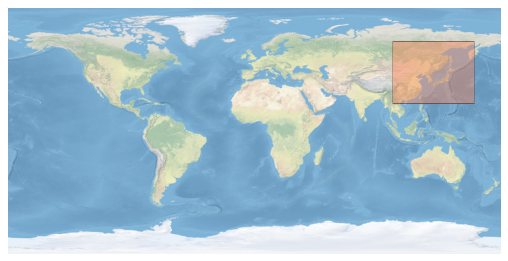

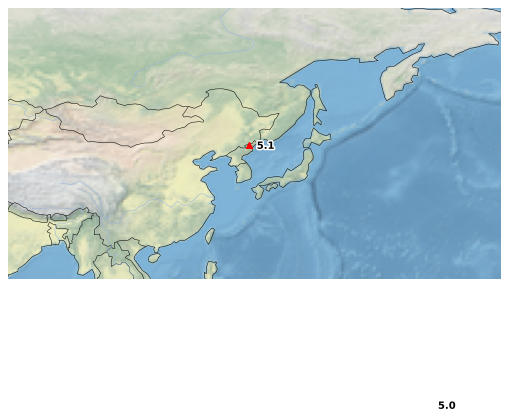

In [12]:
box = sgeom.box(minx=100, maxx=160, miny=20, maxy=65)
x0, y0, x1, y1 = box.bounds
projection = ccrs.PlateCarree(central_longitude=0)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(211, projection=projection)
# plt.plot(129,42,
#          color='red',marker='^',
#          transform=ccrs.Geodetic(),
#          )
ax1.add_geometries([box], projection, facecolor='coral',
                   edgecolor='black', alpha=0.4)
ax1.stock_img()

box = sgeom.box(minx=80, maxx=180, miny=15, maxy=70)
x0, y0, x1, y1 = box.bounds
fig = plt.figure(figsize=(11, 11))
ax2 = fig.add_subplot(212, projection=projection)
ax2.coastlines()
ax2.stock_img()
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.RIVERS)
ax2.set_extent([x0, x1, y0, y1], projection)
plt.plot([129, 129], [42, 42],
         color='red', linewidth=1, marker='^',
         transform=ccrs.Geodetic(),
         )
cat1.plot(fig=fig, show=False, title="", colorbar=False)

pass

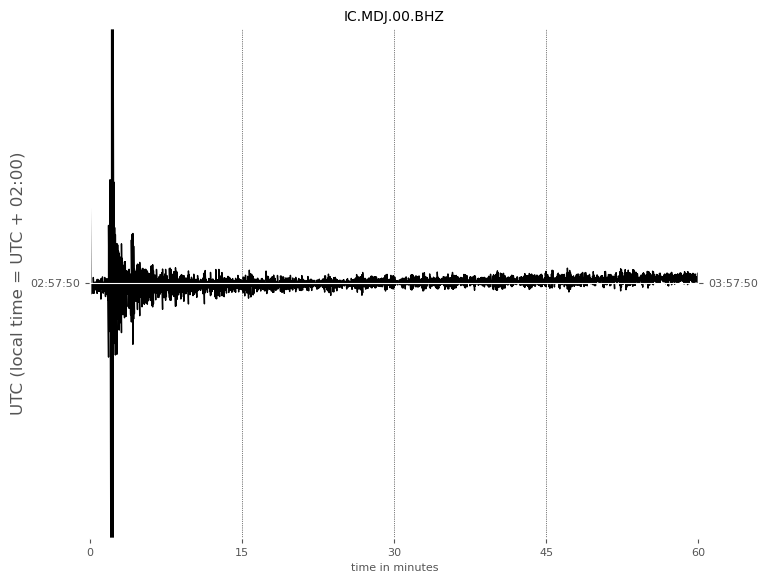

In [13]:
sst = st_2013.copy()
sst.filter("lowpass", freq=0.2)
sst.plot(type="dayplot", interval=60, right_vertical_labels=True,
        vertical_scaling_range=5e3, one_tick_per_line=True, color=['k'])
pass

In [14]:
cat_17 = c_fdsn.get_events(minmagnitude=5.1, starttime=UTCDateTime(2017,9,3), endtime=UTCDateTime(2017,9,4))
event = cat_17[0]
start = event.origins[0].time
end = start + 60 * 60
stn = c_fdsn.get_waveforms(network="IC", station="MDJ",location="*", channel="*", starttime=start, endtime=end)
st_2017 = stn[2]
t1_17 = st_2017.stats.starttime
t2_17 = st_2017.stats.endtime
cat17 = c_fdsn.get_events(starttime=t1_17-10, endtime=t2_17, minmagnitude=6.0)
print(cat_17[0].magnitudes[0].mag)

6.3


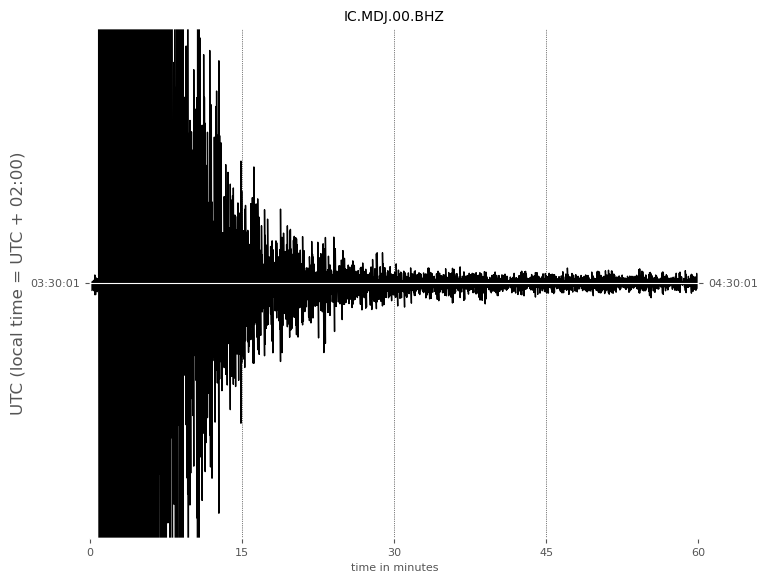

In [15]:
sst = st_2017.copy()
sst.filter("lowpass", freq=0.5)
sst.plot(type="dayplot", interval=60, right_vertical_labels=True,
        vertical_scaling_range=5e4, one_tick_per_line=True, color=['k'])
pass

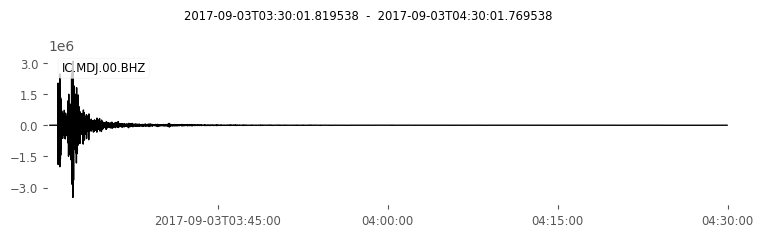

In [16]:
st_2017.plot()
pass

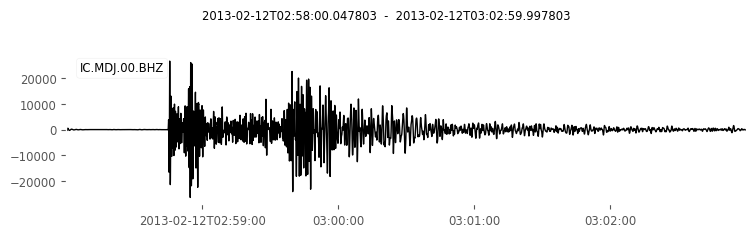

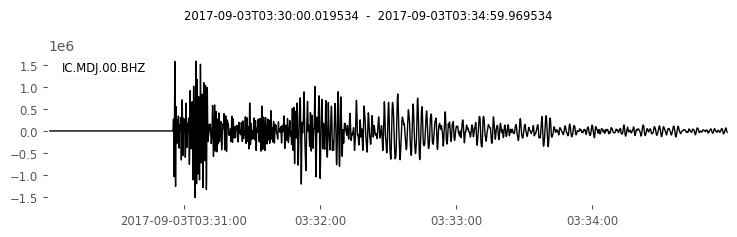

In [17]:
template= read('https://examples.obspy.org/IC.MDJ.2013.043.mseed')
template.filter('bandpass', freqmin=0.5, freqmax=2)
start_2013 = template[0].stats.starttime
end_2013 = template[0].stats.endtime
template.plot()
stream = read('https://examples.obspy.org/IC.MDJ.2017.246.mseed')
stream.filter('bandpass', freqmin=0.5, freqmax=2)
start_2017 = stream[0].stats.starttime
end_2017 = stream[0].stats.endtime
stream.plot(starttime=start_2017+60*30, endtime=end_2017-60*85)
pass

In [18]:
pick = UTCDateTime('2013-02-12T02:58:44.95')
template.trim(pick, pick + 150)

1 Trace(s) in Stream:
IC.MDJ.00.BHZ | 2013-02-12T02:58:44.947803Z - 2013-02-12T03:01:14.947803Z | 20.0 Hz, 3001 samples

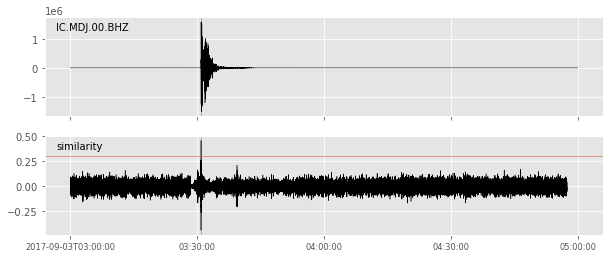

[{'time': 2017-09-03T03:30:55.319534Z,
  'similarity': 0.460202186521317,
  'template_id': 0}]

In [19]:
height = 0.3  # similarity threshold
distance = 10  # distance between detections in seconds
detections, sims = correlation_detector(stream, template, height, distance, plot=stream)
detections

The threshold is lowered to 0.2 to detect also the collapse which occurred around 8 minutes after the 2013 test.

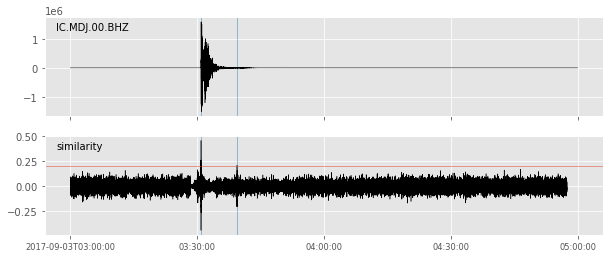

[{'time': 2017-09-03T03:30:55.321731Z,
  'similarity': 0.460202186521317,
  'template_id': 0},
 {'time': 2017-09-03T03:39:25.771731Z,
  'similarity': 0.21099726068286545,
  'template_id': 0}]

In [20]:
height = 0.2  # lower threshold
detections, sims = correlation_detector(stream, template, height, distance, template_times=pick, plot=stream)
detections

# July 8, 1989, Kazakhstan (recorded by a Chinese station)

<Figure size 360x720 with 0 Axes>

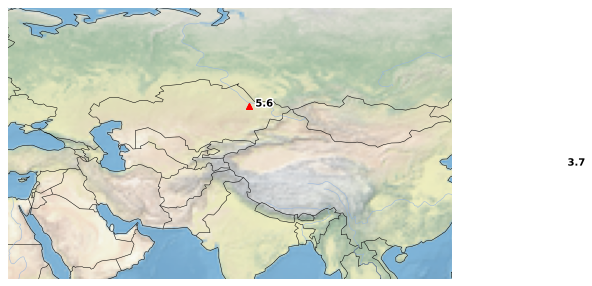

In [21]:
tmp1 = UTCDateTime("1989-07-08T03:40:00.0")
tmp2 = UTCDateTime("1989-07-08T04:05:00.0")
cat_89 = c_fdsn.get_events(minmagnitude=3.7, starttime=tmp1-60*60, endtime=tmp2)
projection = ccrs.PlateCarree(central_longitude=0)
plt.figure(figsize=(5, 10))

box = sgeom.box(minx=30, maxx=120, miny=15, maxy=70)
x0, y0, x1, y1 = box.bounds
fig = plt.figure(figsize=(11, 11))
ax2 = fig.add_subplot(212, projection=projection)
ax2.coastlines()
ax2.stock_img()
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.RIVERS)
ax2.set_extent([x0, x1, y0, y1], projection)
plt.plot([79, 79], [50, 50],
         color='red', linewidth=1, marker='^',
         transform=ccrs.Geodetic(),
         )
cat_89.plot(fig=fig, show=False, title="", colorbar=False)
pass


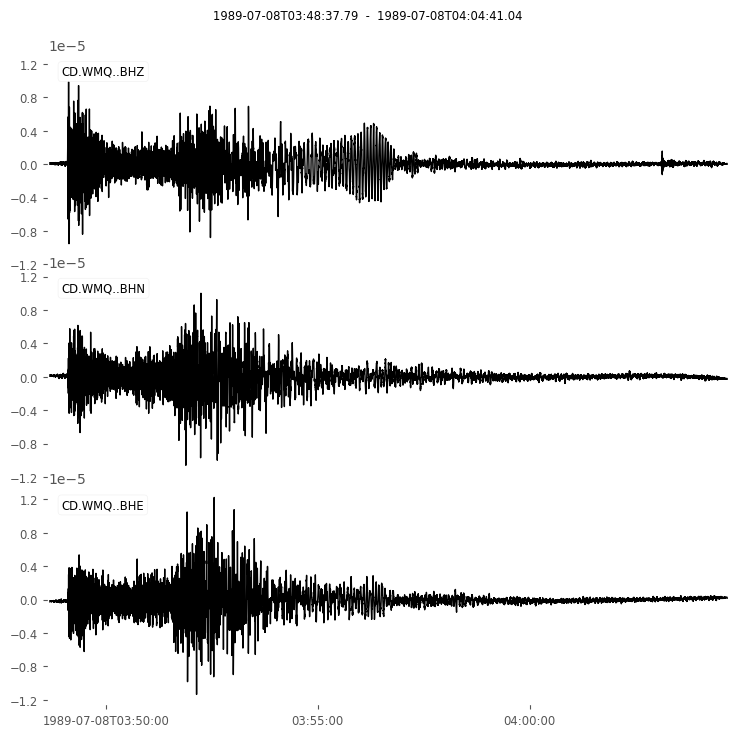

In [22]:

dat = c_fdsn.get_waveforms("CD", "WMQ", "", "BH*", tmp1, tmp2, attach_response = True)
dat.detrend('linear')
dat.detrend('demean')
dat.remove_response(output="VEL")
dat.detrend('linear')
dat.detrend('demean')
dat.plot()
pass

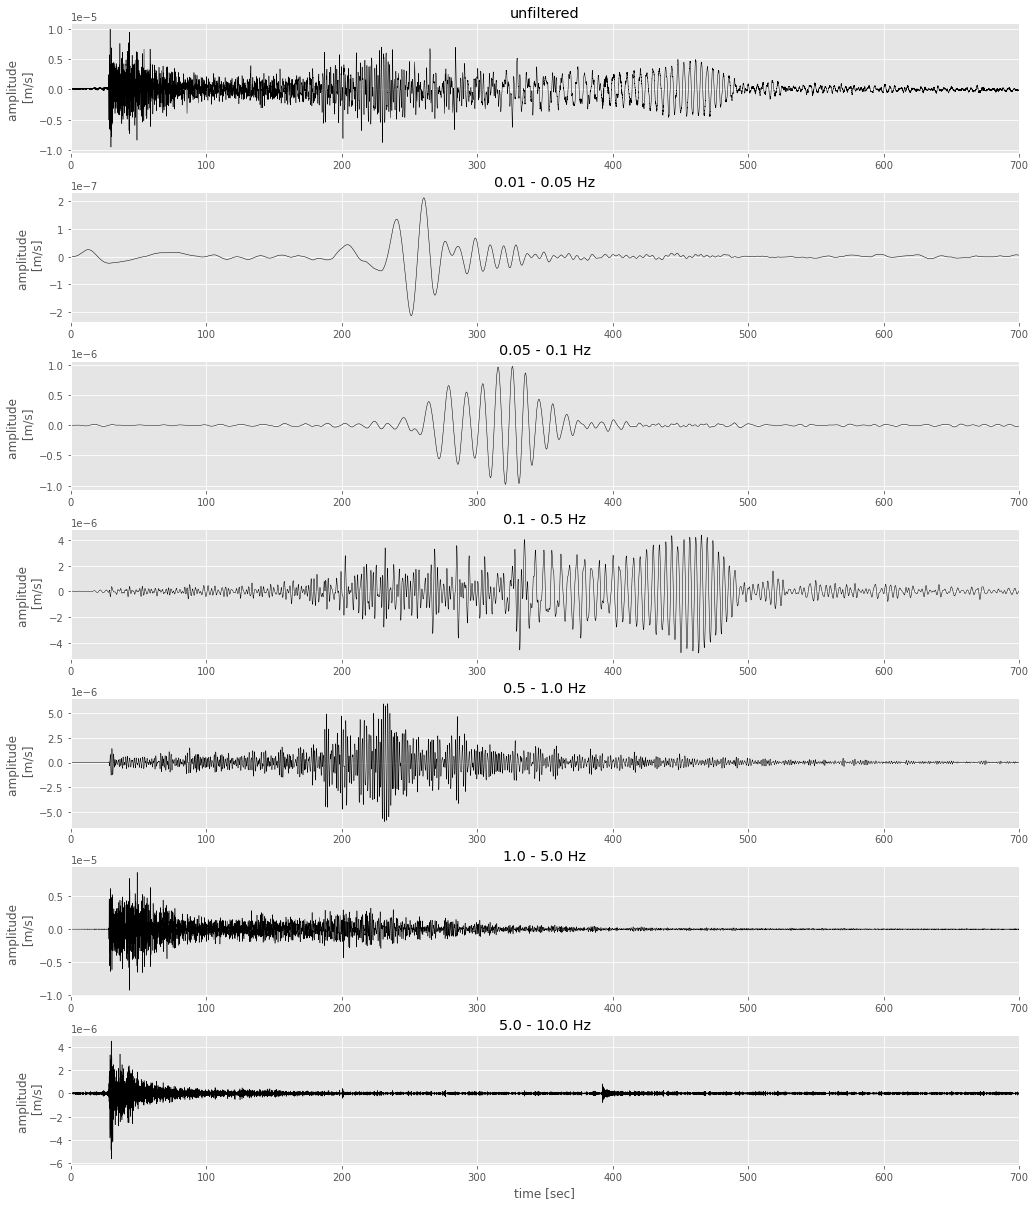

In [23]:
chanel = 2
tm = dat[chanel].times()
xmin = 0
xmax = 700

dat1 = dat[chanel].copy()
dat2 = dat[chanel].copy()
dat2.filter(type="bandpass", freqmin=0.01, freqmax=0.05)
dat3 = dat[chanel].copy()
dat3.filter(type="bandpass", freqmin=0.05, freqmax=0.1)
dat4 = dat[chanel].copy()
dat4.filter(type="bandpass", freqmin=0.1, freqmax=0.5)
dat5 = dat[chanel].copy()
dat5.filter(type="bandpass", freqmin=0.5, freqmax=1)
dat6 = dat[chanel].copy()
dat6.filter(type="bandpass", freqmin=1., freqmax=5.)
dat7 = dat[chanel].copy()
dat7.filter(type="bandpass", freqmin=5., freqmax=10.)

plt.rcParams['figure.figsize'] = 17, 21
fig = plt.figure()
ax1 = fig.add_subplot(7,1,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat1.data, 'k')
plt.xlim(xmin, xmax)
plt.title('unfiltered')
plt.ylabel('amplitude \n [m/s]')
ax2 = fig.add_subplot(7,1,2)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat2.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.01 - 0.05 Hz')
plt.ylabel('amplitude \n [m/s]')
ax3 = fig.add_subplot(7,1,3)
ax3.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat3.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.05 - 0.1 Hz')
plt.ylabel('amplitude \n [m/s]')
ax4 = fig.add_subplot(7,1,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat4.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.1 - 0.5 Hz')
plt.ylabel('amplitude \n [m/s]')
ax5 = fig.add_subplot(7,1,5)
ax5.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat5.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.5 - 1.0 Hz')
plt.ylabel('amplitude \n [m/s]')
ax6 = fig.add_subplot(7,1,6)
ax6.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat6.data, 'k')
plt.xlim(xmin, xmax)
plt.title('1.0 - 5.0 Hz')
plt.ylabel('amplitude \n [m/s]')
ax7 = fig.add_subplot(7,1,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat7.data, 'k')
plt.xlim(xmin, xmax)
plt.title('5.0 - 10.0 Hz')
plt.xlabel('time [sec]')
plt.ylabel('amplitude \n [m/s]')
plt.subplots_adjust(hspace=0.3)
plt.show()

# Cross-Correlation Pick Correction

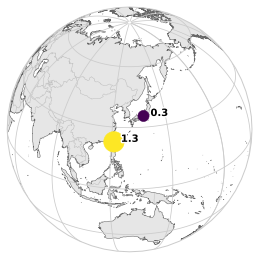

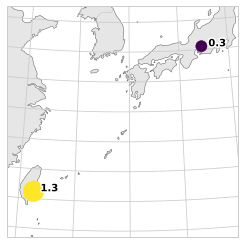

In [24]:
plt.rcParams['figure.figsize'] = 4, 4
plt.style.use('seaborn-whitegrid')
t1 = UTCDateTime("2010-05-27T16:24:33.315000Z")
t2 = UTCDateTime("2010-05-27T16:27:30.585000Z")
cat = c_fdsn.get_events(starttime=t1, endtime=t1+60*60)
cat[-2:].plot(show=False, title="", colorbar=False, projection="ortho", resolution="h")
cat[-2:].plot(show=False, title="", colorbar=False, projection="local", resolution="h")
# print(cat[-2].event_descriptions[0].text)
# print(cat[-1].event_descriptions[0].text)
pass

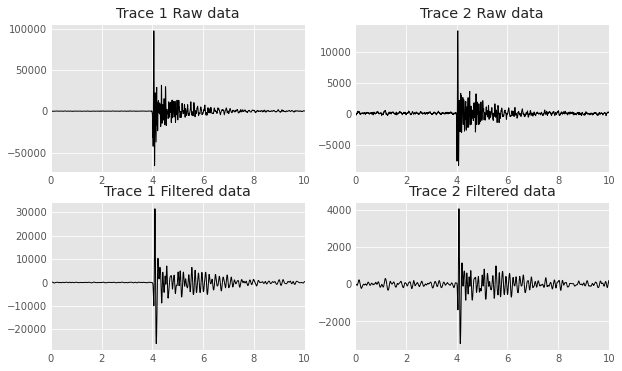

In [25]:
plt.style.use('ggplot')
plt.rcParams["lines.linewidth"] = 1
path = "https://examples.obspy.org/BW.UH1..EHZ.D.2010.147.%s.slist.gz"
tr1 = read(path % ("a", )).select(component="Z")[0]
tr2 = read(path % ("b", )).select(component="Z")[0]
# tr1.plot()
# tr2.plot()
tr1_c = tr1.copy()
tr2_c = tr2.copy()
tr1_c.filter("bandpass", freqmin=1, freqmax=10)
tr2_c.filter("bandpass", freqmin=1, freqmax=10)
# tr1_c.plot()
# tr2_c.plot()
# plot all three traces in one plot
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.xlim(0, 10)
plt.title("Trace 1 Raw data")
plt.plot(tr1.times(), tr1.data, 'k')
plt.subplot(222)
plt.xlim(0, 10)
plt.title("Trace 2 Raw data")
plt.plot(tr2.times(), tr2.data, 'k')
plt.subplot(223)
plt.xlim(0, 10)
plt.title("Trace 1 Filtered data")
plt.plot(tr1_c.times(), tr1_c.data, 'k')
plt.subplot(224)
plt.xlim(0, 10)
plt.title("Trace 2 Filtered data")
plt.plot(tr2_c.times(), tr2_c.data, 'k')



In [26]:
x = [([i,i+1],[i,i-1]) for i in range(10)]

for k,l in x:
    print(k,l)

[0, 1] [0, -1]
[1, 2] [1, 0]
[2, 3] [2, 1]
[3, 4] [3, 2]
[4, 5] [4, 3]
[5, 6] [5, 4]
[6, 7] [6, 5]
[7, 8] [7, 6]
[8, 9] [8, 7]
[9, 10] [9, 8]


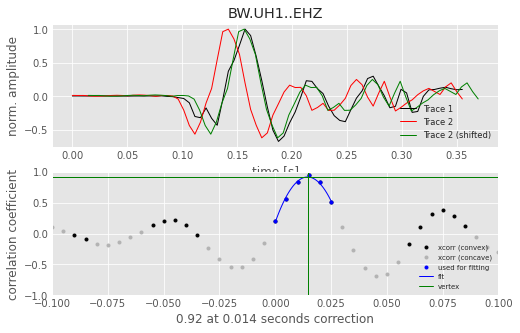

In [27]:
plt.rcParams['figure.figsize'] = 8, 5
# estimate the time correction for pick 2 without any preprocessing and open
# a plot window to visually validate the results
t_before, t_after, cc_maxlag = 0.05, 0.2, 0.1
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, t_before, t_after, cc_maxlag, plot=True)

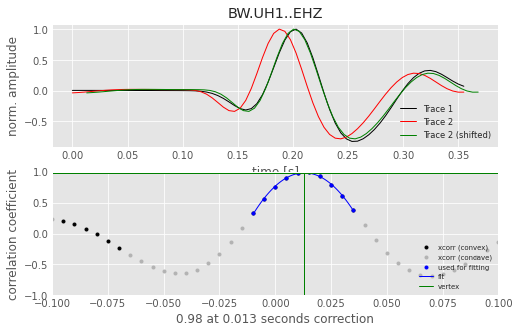

In [28]:
# estimate the time correction with bandpass prefiltering
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, t_before, t_after, cc_maxlag, plot=True,
                                  filter="bandpass",
                                  filter_options={'freqmin': 1, 'freqmax': 10})

# Multi-station detection of swarm earthquakes with multiple templates

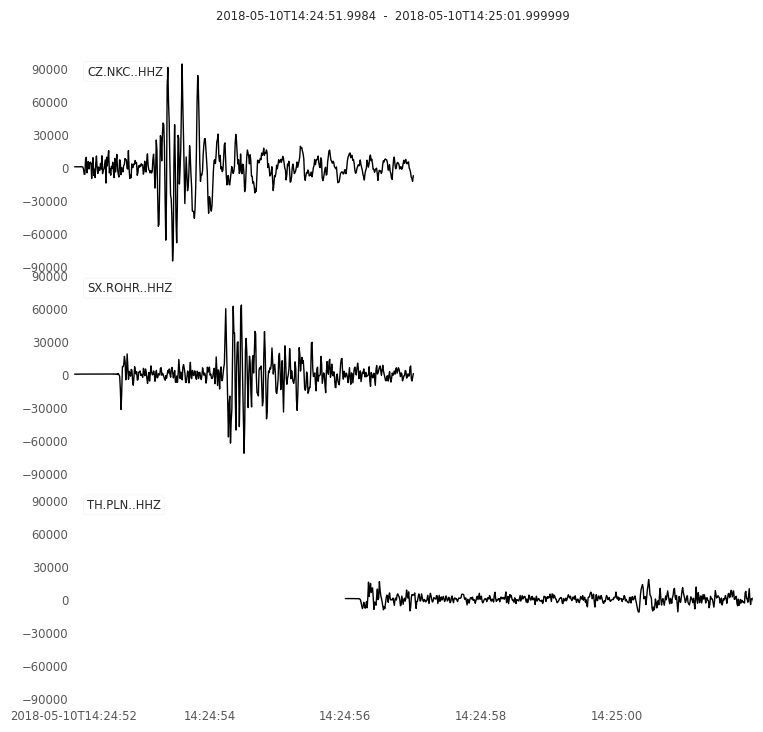

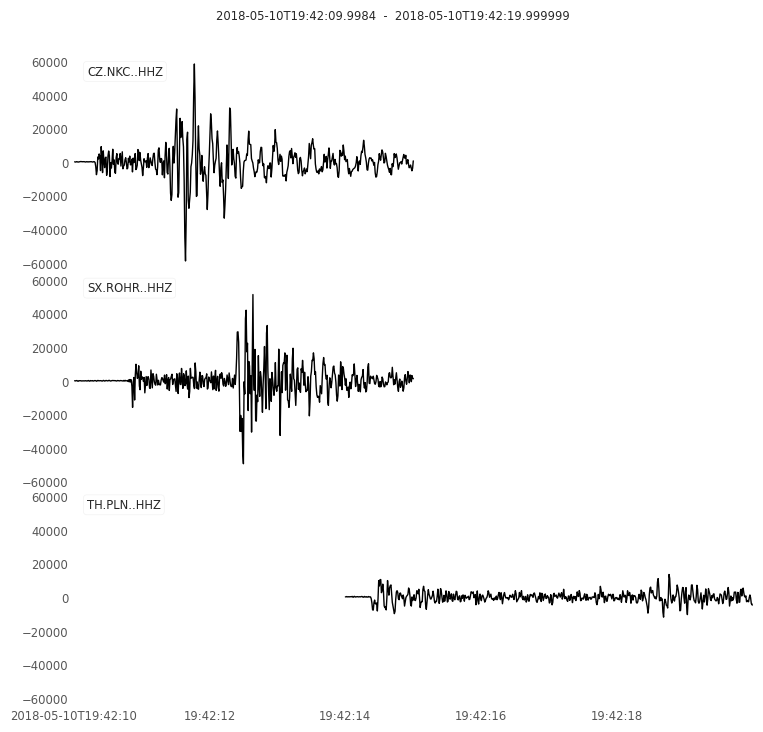

In [29]:
stream = read('https://examples.obspy.org/NKC_PLN_ROHR.HHZ.2018.130.mseed')
stream.filter('highpass', freq=1, zerophase=True)


otimes = [UTCDateTime('2018-05-10 14:24:50'), UTCDateTime('2018-05-10 19:42:08')]
templates = []
for otime in otimes:
    template = stream.select(station='NKC').slice(otime + 2, otime + 7)
    template += stream.select(station='ROHR').slice(otime + 2, otime + 7)
    template += stream.select(station='PLN').slice(otime + 6, otime + 12)
    templates.append(template)

template_magnitudes = [2.9, 2.8]
template_names = ['1st template', '2nd template']
templates[0].plot()
templates[1].plot()
pass

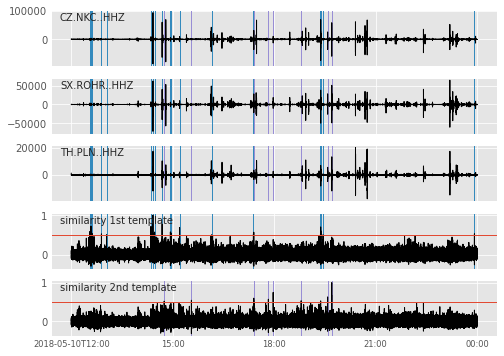

[{'time': 2018-05-10T12:32:46.449999Z,
  'similarity': 0.5827720101598239,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T12:34:58.629999Z,
  'similarity': 0.724891724872,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T12:37:19.729999Z,
  'similarity': 0.5304689350905628,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T12:53:31.499999Z,
  'similarity': 0.5252843843362108,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T13:02:38.099999Z,
  'similarity': 0.5037503963561578,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T14:20:37.049999Z,
  'similarity': 0.5176895916046075,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T14:21:26.449999Z,
  'similarity': 0.7168693658879092,
  'template_name': '1st template',
  'template_id': 0},
 {'time': 2018-05-10T14:24:51.999999Z,
  'similarity': 1.0000000000000002,
  'template_

In [30]:
plt.rcParams['figure.figsize'] = 8, 6
height = 0.5  # similarity threshold
distance = 10  # distance between detections in seconds
detections, sims = correlation_detector(stream, templates, height, distance, template_names=template_names, plot=stream)
detections

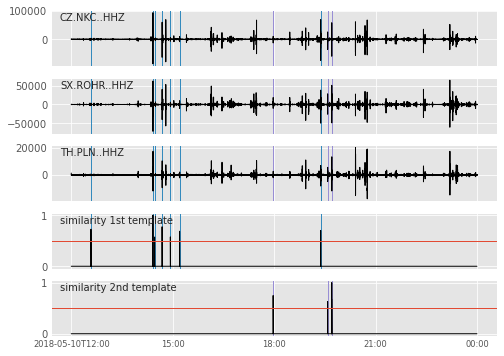

[{'time': 2018-05-10T12:34:56.631599Z,
  'similarity': 0.724891724872,
  'template_name': '1st template',
  'template_id': 0,
  'amplitude_ratio': 0.042826872986209595,
  'magnitude': 1.0756218205928332},
 {'time': 2018-05-10T14:24:50.001599Z,
  'similarity': 1.0000000000000002,
  'template_name': '1st template',
  'template_id': 0,
  'amplitude_ratio': 1.0,
  'magnitude': 2.9},
 {'time': 2018-05-10T14:27:50.921599Z,
  'similarity': 0.5715504339249238,
  'template_name': '1st template',
  'template_id': 0,
  'amplitude_ratio': 0.019130460518598916,
  'magnitude': 0.6089672329605307},
 {'time': 2018-05-10T14:41:07.691599Z,
  'similarity': 0.7728790743937893,
  'template_name': '1st template',
  'template_id': 0,
  'amplitude_ratio': 0.5750792454522206,
  'magnitude': 2.5796369256528813},
 {'time': 2018-05-10T14:55:50.001599Z,
  'similarity': 0.5746771760049966,
  'template_name': '1st template',
  'template_id': 0,
  'amplitude_ratio': 0.07863124925229965,
  'magnitude': 1.4274602340872

In [31]:
def similarity_component_thres(ccs, thres, num_components):
    """Return Trace with mean of ccs
    and set values to zero if number of components above threshold is not reached"""
    ccmatrix = np.array([tr.data for tr in ccs])
    header = dict(sampling_rate=ccs[0].stats.sampling_rate,
                  starttime=ccs[0].stats.starttime)
    comp_thres = np.sum(ccmatrix > thres, axis=0) >= num_components
    data = np.mean(ccmatrix, axis=0) * comp_thres
    return Trace(data=data, header=header)

def simf(ccs):
    return similarity_component_thres(ccs, 0.5, 3)

detections, sims = correlation_detector(
        stream, templates, height, distance, similarity_func=simf, plot=stream,
        template_times=otimes, template_magnitudes=template_magnitudes, template_names=template_names)

detections

# 3

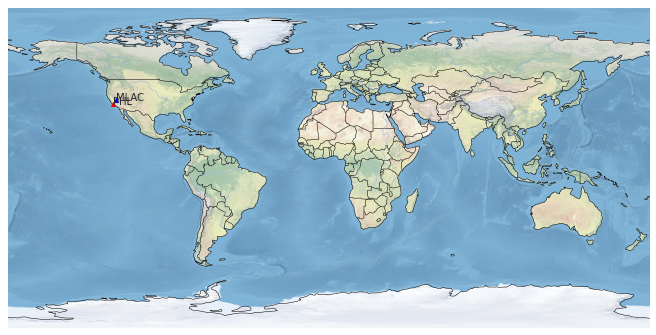

In [32]:
# station locations
latP, lonP = 35.41, -120.55                                  # station PHL
latM, lonM = 37.63, -118.84                                  # station MLAC
box = sgeom.box(minx=-130, maxx=-50, miny=10, maxy=60)
x0, y0, x1, y1 = box.bounds
projection = ccrs.PlateCarree(central_longitude=0)
plt.figure(figsize=(13, 13))
ax1 = plt.subplot(211, projection=projection)
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS)
# ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.RIVERS)
ax1.stock_img()
# ax1.set_extent([x0, x1, y0, y1], projection)


plt.plot(lonP, latP, '^', markersize=4, color='red')
plt.plot(lonM, latM, '^', markersize=4, color='blue')
plt.text(lonP, latP, 'PHL', fontsize=10)
plt.text(lonM, latM, 'MLAC', fontsize=10)
plt.show()

In [ ]:
Image(filename='/mnt/c/Users/yonit/Studies/DSP/shapiro_figure.png')

secondary microseismic peak is roughly between 0.1 and 0.2 Hz. 

primary microseismic peak is roughly between 0.05 and 0.1 Hz

In [35]:
# Functions
# collection of functions used in noise correlation processing

def normalize(tr, clip_factor=6, clip_weight=10, norm_win=None, norm_method="1bit"):

    if norm_method == 'clipping':
        lim = clip_factor * np.std(tr.data)
        tr.data[tr.data > lim] = lim
        tr.data[tr.data < -lim] = -lim

    elif norm_method == "clipping_iter":
        lim = clip_factor * np.std(np.abs(tr.data))

        # as long as still values left above the waterlevel, clip_weight
        while tr.data[np.abs(tr.data) > lim] != []:
            tr.data[tr.data > lim] /= clip_weight
            tr.data[tr.data < -lim] /= clip_weight

    elif norm_method == 'ramn':
        lwin = tr.stats.sampling_rate * norm_win
        st = 0                                               # starting point
        N = lwin                                             # ending point

        while N < tr.stats.npts:
            win = tr.data[st:N]

            w = np.mean(np.abs(win)) / (2. * lwin + 1)

            # weight center of window
            tr.data[st + lwin / 2] /= w

            # shift window
            st += 1
            N += 1

        # taper edges
        taper = get_window(tr.stats.npts)
        tr.data *= taper

    elif norm_method == "1bit":
        tr.data = np.sign(tr.data)
        tr.data = np.float32(tr.data)

    return tr


def get_window(N, alpha=0.2):

    window = np.ones(N)
    x = np.linspace(-1., 1., N)
    ind1 = (abs(x) > 1 - alpha) * (x < 0)
    ind2 = (abs(x) > 1 - alpha) * (x > 0)
    window[ind1] = 0.5 * (1 - np.cos(np.pi * (x[ind1] + 1) / alpha))
    window[ind2] = 0.5 * (1 - np.cos(np.pi * (x[ind2] - 1) / alpha))
    return window


def whiten(tr, freqmin, freqmax):

    nsamp = tr.stats.sampling_rate

    n = len(tr.data)
    if n == 1:
        return tr
    else:
        frange = float(freqmax) - float(freqmin)
        nsmo = int(np.fix(min(0.01, 0.5 * (frange)) * float(n) / nsamp))
        f = np.arange(n) * nsamp / (n - 1.)
        JJ = ((f > float(freqmin)) & (f<float(freqmax))).nonzero()[0]

        # signal FFT
        FFTs = np.fft.fft(tr.data)
        FFTsW = np.zeros(n) + 1j * np.zeros(n)

        # Apodization to the left with cos^2 (to smooth the discontinuities)
        smo1 = (np.cos(np.linspace(np.pi / 2, np.pi, nsmo+1))**2)
        FFTsW[JJ[0]:JJ[0]+nsmo+1] = smo1 * np.exp(1j * np.angle(FFTs[JJ[0]:JJ[0]+nsmo+1]))

        # boxcar
        FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = np.ones(len(JJ) - 2 * (nsmo+1))\
        * np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))

        # Apodization to the right with cos^2 (to smooth the discontinuities)
        smo2 = (np.cos(np.linspace(0, np.pi/2, nsmo+1))**2)
        espo = np.exp(1j * np.angle(FFTs[JJ[-1]-nsmo:JJ[-1]+1]))
        FFTsW[JJ[-1]-nsmo:JJ[-1]+1] = smo2 * espo

        whitedata = 2. * np.fft.ifft(FFTsW).real

        tr.data = np.require(whitedata, dtype="float32")

        return tr


def correlateNoise(st, stations, corrwin):

    print ('correlating stations', (stations[0], stations[1]))

    # initialize sliding timewindow (length = corrwin) for correlation
    # start 1 corrwin after the start to account for different stream lengths
    timewin = st.select(station=stations[1])[0].stats.starttime + corrwin

    # loop over timewindows
    # stop 1 corrwin before the end to account for different stream lengths
    while timewin < st.select(station=stations[0])[-1].stats.endtime - 2*corrwin:
        sig1 = st.select(station=stations[0]).slice(timewin, timewin+corrwin)
        sig1.merge(method=0, fill_value=0)
        sig2 = st.select(station=stations[1]).slice(timewin, timewin+corrwin)
        sig2.merge(method=0, fill_value=0)
        xcorr = np.correlate(sig1[0].data, sig2[0].data, 'same')

        try:
            # build array with all correlations
            corr = np.vstack((corr, xcorr))
        except:
            # if corr doesn't exist yet
            corr = xcorr

        # shift timewindow by one correlation window length
        timewin += corrwin

        # stack the correlations; normalize
        stack = np.sum(corr, 0)
        stack = stack / float((np.abs(stack).max()))
    print ("...done")

    return corr, stack


def plotStack(st, stack, maxlag, figurename=None):

    # define the time vector for the correlation (length of corr = corrwin + 1)
    limit = (len(stack) / 2.) * st[0].stats.delta
    timevec = np.arange(-limit, limit, st[0].stats.delta)

    plt.plot(timevec, stack, 'k')
    stations = list(set([_i.stats.station for _i in st]))
    plt.title("Stacked correlation between %s and %s" % (stations[0], stations[1]))
    plt.xlim(-maxlag, maxlag)
    plt.xlabel('time [s]')

    if figurename is not None:
        fig.savefig(figurename, format="pdf")
    else:
        plt.show()


def plotXcorrEvent(st, stn, stack, maxlag, acausal=False, figurename=None):

    eventtime = UTCDateTime(1998,7,15,4,53,21,0)                 # event near MLAC

    # station locations
    latP, lonP = 35.41, -120.55                                  # station PHL
    latM, lonM = 37.63, -118.84                                  # station MLAC
    latE, lonE = 37.55, -118.809                                 # event 1998

    # calculate distance between stations
    dist = gps2DistAzimuth(latP, lonP, latM, lonM)[0]            # between PHL and MLAC
    distE = gps2DistAzimuth(latP, lonP, latE, lonE)[0]           # between event and PHL
                                                                 #
    # CROSSCORRELATION
    # reverse stack to plot acausal part (= negative times of correlation)
    if acausal:
        stack = stack[::-1]

    # find center of stack
    c = int(np.ceil(len(stack)/2.) + 1)

    #cut stack to maxlag
    stack = stack[c - maxlag * int(np.ceil(stn[0].stats.sampling_rate)) : c + maxlag * int(np.ceil(stn[0].stats.sampling_rate))]

    # find new center of stack
    c2 = int(np.ceil(len(stack)/2.) + 1)

    # define time vector for cross correlation
    limit = (len(stack) / 2.) * stn[0].stats.delta
    timevec = np.arange(-limit, limit, stn[0].stats.delta)
    # define timevector: dist / t
    timevecDist = dist / timevec

    # EVENT
    ste = st.copy()
    st_PHL_e = ste.select(station='PHL')

    # cut down event trace to 'maxlag' seconds
    dt = len(stack[c2:])/stn[0].stats.sampling_rate                  #xcorrlength
    st_PHL_e[0].trim(eventtime, eventtime + dt)

    # create time vector for event signal
    # extreme values:
    limit = st_PHL_e[0].stats.npts * st_PHL_e[0].stats.delta
    timevecSig = np.arange(0, limit, st_PHL_e[0].stats.delta)

    # PLOTTING
    fig = plt.figure(figsize=(12.0, 6.0))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot noise correlation
    ax1.plot(timevecDist[c2:], stack[c2:], 'k')
    ax1.set_title('Noise correlation between MLAC and PHL')

    # plot event near MLAC measured at PHL
    ax2.plot(distE/timevecSig, st_PHL_e[0].data / np.max(np.abs(st_PHL_e[0].data)), 'r')
    ax2.set_title('Event near MLAC observed at PHL')

    ax2.set_xlim((0, 8000))
    ax1.set_xlim((0, 8000))

    ax2.set_xlabel("group velocity [m/s]")

    if figurename is not None:
        fig.savefig(figurename, format="pdf")
    else:
        plt.show()

In [36]:
#noise data from MLAC and PHL stations

# get noise data for station MLAC
stn = obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/noise.CI.MLAC.LHZ.2004.294.2005.017.mseed')
# get noise data for the station PHL and add it to the previous stream
stn += obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/noise.CI.PHL.LHZ.2004.294.2005.017.mseed')

In [37]:
# Preprocessing 1
stp = stn.copy()                                                 # copy stream
t = stp[0].stats.starttime
stp.trim(t, t + 4 * 86400)                                       # shorten stream for quicker processing

stp.detrend('linear')                                            # remove trends using detrend
stp.taper(max_percentage=0.05, type='cosine')                    # taper the edges
stp.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True) # filter data of all traces in the streams
# Preprocessing 2
st = stp.copy()                            # copy stream

for tr in st:
    tr = normalize(tr, norm_method="1bit")
    tr = whiten(tr, 0.1, 0.2)
print ('done!')

done!


correlating stations ('MLAC', 'PHL')
...done


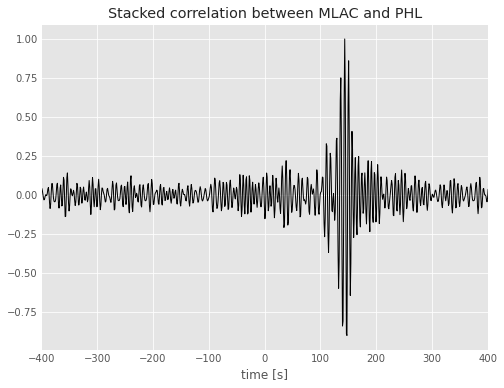

In [38]:
# Cross-correlate
xcorr, stack = correlateNoise(st, ['MLAC','PHL'], 7200)
plotStack(st,stack,400)
ste = obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/event.CI.PHL.LHZ.1998.196.1998.196.mseed')
# Preprocessing
ste.detrend('linear')
ste.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
for tr in ste:
    tr = whiten(tr, 0.1, 0.2)

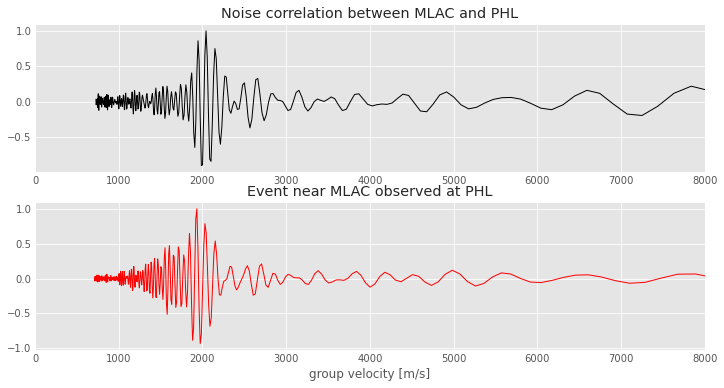

In [39]:
# Plotting

plotXcorrEvent(ste, stn, stack, 400)